In [1]:
import numpy as np
import matplotlib.pyplot as plt
from VQE import VQE
from GroupingAlgorithm import *
from utils import *
# Importing standard Qiskit libraries
from qiskit import IBMQ, QuantumCircuit
from qiskit.providers.aer import AerSimulator
from qiskit.circuit.library import EfficientSU2
from qiskit.utils.quantum_instance import QuantumInstance
from qiskit.algorithms import NumPyMinimumEigensolver
from qiskit.ignis.mitigation.measurement import CompleteMeasFitter
from qiskit_nature.circuit.library import HartreeFock
from qiskit_nature.transformers import FreezeCoreTransformer
from qiskit_nature.drivers import PyQuanteDriver
from qiskit_nature.problems.second_quantization.electronic import ElectronicStructureProblem
from qiskit_nature.mappers.second_quantization import ParityMapper, JordanWignerMapper
from qiskit_nature.converters.second_quantization.qubit_converter import QubitConverter
from qiskit_nature.algorithms.ground_state_solvers.minimum_eigensolver_factories import NumPyMinimumEigensolverFactory
from qiskit_nature.algorithms.ground_state_solvers import GroundStateEigensolver
from qiskit.opflow.primitive_ops import Z2Symmetries
from qiskit.opflow import converters
from qiskit.algorithms.optimizers import SPSA
from IPython.display import display, clear_output

In [2]:
IBMQ.load_account()
provider      = IBMQ.get_provider(hub='ibm-q-csic', group='internal', project='iff-csic') 
backend_paris = provider.get_backend('ibmq_paris')
WC_paris      = get_backend_conectivity(backend_paris)
backend_sim   = AerSimulator(method="statevector") # Backend for simulation
backend_noise = AerSimulator.from_backend(backend_paris)
NUM_SHOTS = 2**13  # Number of shots for each circuit

In [3]:
# molecule = 'Li 0.0 0.0 0.0; H 0.0 0.0 1.5474'
# driver = PyQuanteDriver(molecule)
# qmolecule = driver.run()
# freezeCoreTransfomer = FreezeCoreTransformer( freeze_core=True, remove_orbitals= [3,4] )
# problem = ElectronicStructureProblem(driver,q_molecule_transformers=[freezeCoreTransfomer])

# # Generate the second-quantized operators
# second_q_ops = problem.second_q_ops()

# # Hamiltonian
# main_op = second_q_ops[0]

# # Setup the mapper and qubit converter
# mapper_type = 'ParityMapper'
# mapper = ParityMapper()

# converter = QubitConverter( mapper=mapper, two_qubit_reduction=True, z2symmetry_reduction=[1,1],) #1] 

# # The fermionic operators are mapped to qubit operators
# num_particles = (problem.molecule_data_transformed.num_alpha, problem.molecule_data_transformed.num_beta)

# num_spin_orbitals = 2 * problem.molecule_data_transformed.num_molecular_orbitals

# qubit_op = converter.convert(main_op, num_particles=num_particles)

# num_qubits = qubit_op.num_qubits
# WC = list(range(num_qubits))
# WC = list(permutations(list(range(num_qubits)),2))

# init_state = HartreeFock(num_spin_orbitals, num_particles, converter)

# print( num_qubits )
# print( qubit_op )

In [4]:
num_qubits = 2
qubit_op = RandomHamiltonian( num_qubits, 6 )
WC = list(range(num_qubits))
WC = list(permutations(list(range(num_qubits)),2))
init_state = QuantumCircuit(num_qubits)

In [5]:
print( qubit_op )

SummedOp([
  YZ,
  IZ,
  ZX,
  ZY,
  YY,
  IZ
])


In [6]:
result_exact = NumPyMinimumEigensolver().compute_minimum_eigenvalue(qubit_op)
result_exact.eigenvalue 

(-3.645751311064595+3.5411233196088594e-17j)

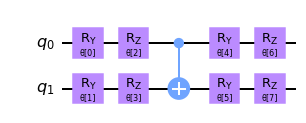

In [7]:
entangled_layer = []
for qbs in WC_paris :
    if qbs[0]<qbs[1] and qbs[1]<num_qubits :
        entangled_layer.append(qbs)

ansatz = init_state.compose( EfficientSU2(num_qubits,['ry','rz'], entanglement=entangled_layer, reps=1 ) )
ansatz.draw(output='mpl')

In [8]:
def callback( evals, params ):  
    display("{}, {}".format(len(evaluations),evals))
    clear_output(wait=True)
    parameters.append(params)
    evaluations.append(evals)

parameters  = []
evaluations = []

In [9]:
optimizer = SPSA( maxiter=100, last_avg=1 )

In [10]:
num_var = ansatz.num_parameters
pars = [0.01] * num_var

In [11]:
result_exact.eigenvalue 

(-3.645751311064595+3.5411233196088594e-17j)

In [12]:
solver = VQE( ansatz, optimizer, pars, grouping = 'Entangled' )
results = solver.compute_minimum_eigenvalue(qubit_op)
print( results.eigenvalue )

-3.458984375


In [13]:
solver = VQE( ansatz, optimizer, pars, grouping = 'TPB' )
results = solver.compute_minimum_eigenvalue(qubit_op)
print( results.eigenvalue )

-3.640625


In [14]:
solver = VQE( ansatz, optimizer, pars, grouping = 'Entangled', conectivity = WC_paris )
results = solver.compute_minimum_eigenvalue(qubit_op)
print( results.eigenvalue )

-3.755859375


In [15]:
parameters  = []
evaluations = []
solver = VQE( ansatz, optimizer, pars, grouping = 'Entangled', callback=callback )
results = solver.compute_minimum_eigenvalue(qubit_op)
print( results.eigenvalue )

-3.55859375


In [16]:
# parameters  = []
# evaluations = []
# optimizer   = SPSA( maxiter=50, last_avg=1 )
# solver = VQE( ansatz, optimizer, pars, grouping = 'Entangled', callback=callback, quantum_instance=backend_noise )
# results = solver.compute_minimum_eigenvalue(qubit_op)
# print( results.eigenvalue )

In [17]:
# plt.plot( evaluations )

In [18]:
qi = QuantumInstance( backend_sim, shots = NUM_SHOTS )
parameters  = []
evaluations = []
optimizer   = SPSA( maxiter=50, last_avg=1 )
solver = VQE( ansatz, optimizer, pars, grouping = 'Entangled', callback=callback, quantum_instance=qi )
results = solver.compute_minimum_eigenvalue(qubit_op)
print( results.eigenvalue )

-29.2265625


In [36]:
print(results)

OrderedDict([   ('aux_operator_eigenvalues', None),
                ('cost_function_evals', 100),
                (   'eigenstate',
                    {   '00': 0.2628531850196988,
                        '01': 0.6381430580206918,
                        '10': 0.18553659510996745,
                        '11': 0.699469665174981}),
                ('eigenvalue', -29.2265625),
                (   'optimal_parameters',
                    {   ParameterVectorElement(θ[0]): -0.6473682939489743,
                        ParameterVectorElement(θ[1]): -1.759905825997268,
                        ParameterVectorElement(θ[2]): 0.18472436137445564,
                        ParameterVectorElement(θ[3]): 1.3924870573345818,
                        ParameterVectorElement(θ[4]): -3.019899448196948,
                        ParameterVectorElement(θ[5]): 0.47057785605775715,
                        ParameterVectorElement(θ[6]): 1.9092911243661457,
                        ParameterVectorElement(θ[7]): 3.62

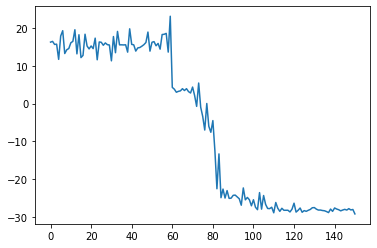

In [19]:
plt.plot( evaluations )

In [20]:
solver.ansatz

In [21]:
solver.cleanup_parameterized_circuits

<bound method VariationalAlgorithm.cleanup_parameterized_circuits of <VQE.VQE object at 0x000002837CABC288>>

In [22]:
solver.construct_expectation

<bound method VQE.construct_expectation of <VQE.VQE object at 0x000002837CABC288>>

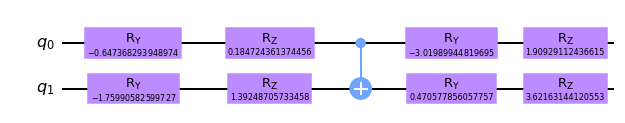

In [23]:
solver.get_optimal_circuit().draw(output='mpl')

In [24]:
solver.get_optimal_cost()

-29.2265625

In [25]:
solver.get_optimal_vector()

{'00': 0.2667714231088105,
 '11': 0.7014737555229704,
 '01': 0.6307354028731065,
 '10': 0.19733329594242327}

In [26]:
# solver.get_prob_vector_for_params()

In [27]:
# solver.get_probabilities_for_counts()

In [28]:
solver.initial_point

[0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01]

In [29]:
solver.optimal_params

array([-0.64736829, -1.75990583,  0.18472436,  1.39248706, -3.01989945,
        0.47057786,  1.90929112,  3.62163144])

In [30]:
solver.optimizer

In [31]:
solver.quantum_instance

In [32]:
solver.supports_aux_operators()

False

In [33]:
print( solver.print_settings() )


==================== Setting of VQE ============================
Algorithm: VQE
-- ansatz_params: [ParameterVectorElement(θ[0]), ParameterVectorElement(θ[1]), ParameterVectorElement(θ[2]), ParameterVectorElement(θ[3]), ParameterVectorElement(θ[4]), ParameterVectorElement(θ[5]), ParameterVectorElement(θ[6]), ParameterVectorElement(θ[7])]
-- ansatz:      ┌──────────┐┌──────────┐     ┌──────────┐┌──────────┐
q_0: ┤ RY(θ[0]) ├┤ RZ(θ[2]) ├──■──┤ RY(θ[4]) ├┤ RZ(θ[6]) ├
     ├──────────┤├──────────┤┌─┴─┐├──────────┤├──────────┤
q_1: ┤ RY(θ[1]) ├┤ RZ(θ[3]) ├┤ X ├┤ RY(θ[5]) ├┤ RZ(θ[7]) ├
     └──────────┘└──────────┘└───┘└──────────┘└──────────┘
-- quantum_instance: 
Qiskit Terra version: 0.17.0
Backend: 'aer_simulator_statevector (None)', with following setting:
{'basis_gates': ['ccx', 'cp', 'cswap', 'csx', 'cu1', 'cu2', 'cu3', 'cx', 'cy', 'cz', 'delay', 'diagonal', 'h', 'id', 'initialize', 'mcphase', 'mcr', 'mcrx', 'mcry', 'mcrz', 'mcswap', 'mcsx', 'mcu1', 'mcu2', 'mcu3', 'mcx', 'mcx_gray', 